Commande pip pour installer toute les librairies

In [ ]:
pip install pandas numpy opencv-python-headless tensorflow keras scikit-learn tkinter

Importation des librairies 

In [6]:
import os
import json
import cv2
import pandas as pd
import numpy as np
from tkinter import Tk, filedialog
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.preprocessing.image import load_img, img_to_array
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


Définition du modèle, choix des données test/validation, fonction UNet...

In [7]:
# Chargement du fichier CSV
df = pd.read_csv('/Users/quentinlandon/Desktop/GIT_Projet_theo/APP_IA_TL_QL_dev/informations_masques.csv')

# Extraction des chemins des images brutes et des masques
images_paths = df['pathimg'].values
masks_paths = df['pathmask'].values

# Fonction pour charger les images et les masques
def load_images_and_masks(images_paths, masks_paths):
    images = []
    masks = []
    for img_path, mask_path in zip(images_paths, masks_paths):
        img = load_img(img_path, target_size=(256, 256))
        mask = load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        images.append(img_to_array(img))
        masks.append(img_to_array(mask))
    return np.array(images), np.array(masks)

# Chargement des images et des masques
images, masks = load_images_and_masks(images_paths, masks_paths)

# Division des données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Définir input_shape
input_shape = (256, 256, 3)  # Taille de l'image : 256x256 pixels, 3 canaux (RGB)

# Modifier la couche de sortie pour gérer les classes multiples
def unet_multiclass(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Chemin contractant
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Fond
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Chemin expansif
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Couche de sortie pour les classes multiples avec softmax
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Déterminer le nombre de classes à partir des masques d'entraînement
num_classes = np.max([len(np.unique(mask)) for mask in y_train])

# Création du modèle U-Net pour plusieurs classes
model = unet_multiclass(input_shape, num_classes)

# Compilation du modèle avec la perte et l'optimiseur appropriés
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Limiter les valeurs de pixel dans les masques à un nombre de classes maximum
def limit_mask_classes(mask, num_classes):
    return np.where(mask < num_classes, mask, num_classes - 1)

# Appliquer la fonction de seuillage aux masques d'entraînement et de test
y_train_limited = np.array([limit_mask_classes(mask, num_classes) for mask in y_train])
y_test_limited = np.array([limit_mask_classes(mask, num_classes) for mask in y_test])

# Encodage one-hot des masques
y_train_encoded = to_categorical(y_train_limited, num_classes=max(num_classes, num_classes))
y_test_encoded = to_categorical(y_test_limited, num_classes=max(num_classes, num_classes))


Entrainement du modèle UNET

In [ ]:

# Entraînement du modèle
model.fit(x_train, y_train_encoded, batch_size=32, epochs=10, validation_data=(x_test, y_test_encoded))


Enregistrement du modèle dans le path choisi

In [ ]:
import os
from tkinter import Tk, filedialog

# Créer une fenêtre Tkinter
root = Tk()
root.withdraw()  # Pour cacher la fenêtre principale

# Demander à l'utilisateur de choisir le chemin d'enregistrement
save_path = filedialog.asksaveasfilename(defaultextension=".h5", filetypes=[("Model files", "*.h5")])

# Demander à l'utilisateur le nom du modèle
model_name = input("Veuillez saisir le nom du modèle : ")

# Vérifier si le nom du modèle a été saisi
if not model_name:
    print("Le nom du modèle est vide. Veuillez saisir un nom valide.")
    exit()

# Vérifier si le chemin d'enregistrement a été choisi
if not save_path:
    print("Aucun chemin d'enregistrement sélectionné. L'enregistrement du modèle est annulé.")
    exit()

# Enregistrer le modèle
model.save(os.path.join(save_path, model_name + ".h5"))


Visualiser le modèle, Choisir le path du modèle voulu : 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Precision: 0.8046258851686368
Recall: 0.6821136474609375
F1 Score: 0.6520437914480468


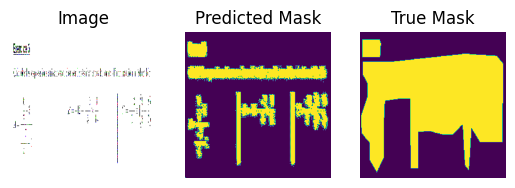

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model


def visualize_result(model_path, option, image_path=None, image=None, true_mask=None):
    # Charger le modèle
    model = load_model(model_path)

    if option == 0:
        # Visualisation des résultats sur des données déjà labellisées
        # Prédiction du masque avec le modèle
        predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
        
        # Convertir les masques prédits et vrais en classes (0, 1, 2, ...)
        predicted_class = np.argmax(predicted_mask, axis=-1)
        true_class = np.argmax(true_mask, axis=-1)
        
        # Calculer les scores de précision, rappel et F-mesure
        precision = precision_score(true_class.flatten(), predicted_class.flatten(), average='weighted')
        recall = recall_score(true_class.flatten(), predicted_class.flatten(), average='weighted')
        f1 = f1_score(true_class.flatten(), predicted_class.flatten(), average='weighted')
        
        # Afficher les scores
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        
        # Afficher l'image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis('off')
        
        # Afficher le masque prédit
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_class, cmap='viridis', vmin=0, vmax=np.max(predicted_class))
        plt.title("Predicted Mask")
        plt.axis('off')
        
        # Afficher le masque vrai
        plt.subplot(1, 3, 3)
        plt.imshow(true_class, cmap='viridis', vmin=0, vmax=np.max(true_class))
        plt.title("True Mask")
        plt.axis('off')
        
        plt.show()
        
    elif option == 1:
        # Visualisation des résultats sur une image brute non labellisée
        # Charger l'image
        image = load_img(image_path, target_size=(256, 256))
        image_array = img_to_array(image)
        
        # Prédiction du masque avec le modèle
        predicted_mask = model.predict(np.expand_dims(image_array, axis=0))[0]
        
        # Convertir le masque prédit en classes (0, 1, 2, ...)
        predicted_class = np.argmax(predicted_mask, axis=-1)
        
        # Afficher l'image et le masque prédit
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_class, cmap='viridis', vmin=0, vmax=np.max(predicted_class))
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.show()

# Chemin du modèle
model_path = input("Entrez le chemin du modèle : ")

# Utilisation de la fonction pour visualiser les résultats
option = int(input("Choisissez l'option (0: Données labellisées, 1: Image brute non labellisée): "))

if option == 0:
    index = int(input("Entrez l'indice de l'image à visualiser : "))
    visualize_result(model_path, option, image=x_test[index], true_mask=y_test_encoded[index])
elif option == 1:
    image_path = input("Entrez le chemin de l'image à visualiser : ")
    visualize_result(model_path, option, image_path=image_path)
else:
    print("Option invalide.")
